# Predicting Solar Panel Adoption - Random Forest Two-Stage Model
#### UC Berkeley MIDS
`Team: Gabriel Hudson, Noah Levy, Laura Williams`

Using the dataset defined in the Data Set Up notebook, train two Random Forest sequential models:
* Random Forest Classifier to predict presence or absence of solar panels  
* Random Forest Regressor to predict solar panel density and analyize most important predictive features.

In [1]:
# imports
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import rfpimp as rfp

%matplotlib inline

In [ ]:
# if necessary, install package for calculating feature importances
#!pip install rfpimp

In [152]:
# load curated dataset
deepsolar = pd.read_csv('../Datasets/deepsolar_LW1_no_geo.csv', index_col=0)

In [153]:
print("Dataset rows and dimensions:", deepsolar.shape)

Dataset rows and dimensions: (71305, 103)


## Pre-process data

* Define outcome variables
* Split into test/train/dev

In [154]:
# create binary outcome variable for stage 1 RF classifier
deepsolar['solar_flag']=deepsolar['number_of_solar_system_per_household'].apply(lambda x: int(x>0))

In [155]:
# Confirm values in new outcome variable
print("New binary outcome variable for Stage 1 random forest classifier 'solar_flag' has", 
      deepsolar['solar_flag'].nunique(), "values:", deepsolar["solar_flag"].min(),
      "and", deepsolar["solar_flag"].max())

New binary outcome variable for Stage 1 random forest classifier 'solar_flag' has 2 values: 0 and 1


Random shuffle and split data into test, training and development sets. Test data will not be used until model and dataset has been optimized on the training and development datasets.

In [156]:
# separate outcome variables and features
X = deepsolar.drop(labels=['solar_flag', 'number_of_solar_system_per_household'], axis=1).values
Y_classifier = deepsolar['solar_flag'].values
Y_regressor = deepsolar['number_of_solar_system_per_household'].values
print("Full featureset shape is", X.shape)
print("Classifier outcome variable shape:", Y_classifier.shape)
print("Regressor outcome variable shape:", Y_regressor.shape)

Full featureset shape is (71305, 102)
Classifier outcome variable shape: (71305,)
Regressor outcome variable shape: (71305,)


In [157]:
# set a random seed to keep the split the same for development when testing different data sets
np.random.seed(0)

# shuffle data
shuffle = np.random.permutation(np.arange(X.shape[0]))
X = X[shuffle]
Y_classifier = Y_classifier[shuffle]
Y_regressor = Y_regressor[shuffle]

# split data and labels into test set and 80% training set
n_train = int(0.8*X.shape[0])
X_train_80 = X[:n_train,:]
X_test = X[n_train:,:]
Y_classifier_train_80 = Y_classifier[:n_train]
Y_classifier_test = Y_classifier[n_train:]
Y_regressor_train_80 = Y_regressor[:n_train]
Y_regressor_test = Y_regressor[n_train:]

# split training data and labels into training and development sets
n_dev = int(0.8*X_train_80.shape[0])
X_train = X_train_80[:n_dev,:]
X_dev = X_train_80[n_dev:,:]
Y_classifier_train = Y_classifier_train_80[:n_dev]
Y_classifier_dev = Y_classifier_train_80[n_dev:]
Y_regressor_train = Y_regressor_train_80[:n_dev]
Y_regressor_dev = Y_regressor_train_80[n_dev:]



print("{:<35}\t{}".format("Training data shape:", X_train.shape))
print("{:<35}\t{}".format("Training outcome variable - classifier:",Y_classifier_train.shape ))
print("{:<35}\t{}".format("Training outcome variable - regressor:",Y_regressor_train.shape ))
print("{:<35}\t{}".format("Dev data shape:", X_dev.shape))
print("{:<35}\t{}".format("Dev outcome variable - classifier:",Y_classifier_dev.shape ))
print("{:<35}\t{}".format("Dev outcome variable - regressor:",Y_regressor_dev.shape ))
print("{:<35}\t{}".format("Test data shape:", X_test.shape))
print("{:<35}\t{}".format("Test outcome variable - classifier:",Y_classifier_test.shape ))
print("{:<35}\t{}".format("Test outcome variable - regressor:",Y_regressor_test.shape ))



Training data shape:               	(45635, 102)
Training outcome variable - classifier:	(45635,)
Training outcome variable - regressor:	(45635,)
Dev data shape:                    	(11409, 102)
Dev outcome variable - classifier: 	(11409,)
Dev outcome variable - regressor:  	(11409,)
Test data shape:                   	(14261, 102)
Test outcome variable - classifier:	(14261,)
Test outcome variable - regressor: 	(14261,)


## Train the model

In [158]:
def train_2stage_model(n, depth, features, 
                       n_R, depth_R, features_R,
                       X_train, Y_classifier_train, Y_regressor_train,
                       X_test, Y_classifier_test, Y_regressor_test):
    """Input: hyperparameters for Stage 1 classifier, hyperparameters for Stage 2 regressor,
    training and test data, and training and test outcome variables for both the
    classifier and regressor.
    Output: classifer model and R squared score, regressor model and R squared score, 
    combined model R squared score"""
    # define and fit classifier
    classifier = RandomForestClassifier(n_estimators=n, max_depth=depth, max_features=features, n_jobs=1)
    classifier.fit(X_train, Y_classifier_train)  
    # define and fit regressor
    regressor = RandomForestRegressor(n_estimators=n_R, max_depth=depth_R, max_features=features_R, n_jobs=1)
    regressor.fit(X_train, Y_regressor_train)
    # calculate individual scores
    classifier_score = classifier.score(X_test,Y_classifier_test)
    regressor_score = regressor.score(X_dev,Y_regressor_dev)
    # calculate combined model scores
    classifier_preds=classifier.predict(X_dev)
    regressor_preds=regressor.predict(X_dev)
    final_preds=regressor_preds*classifier_preds
    combined_score = r2_score(Y_regressor_dev,final_preds)
    
    return classifier, regressor, classifier_score, regressor_score, combined_score
    

In [160]:
# Classifier parameters - use best parameters from Noah's hyperparameter tuning
n = 100
depth = None
features = 'auto'

In [161]:
# Regressor parameters
n_R = 100
depth_R = 15
features_R = 'auto'

In [129]:
# train the full model and report scores using training set and development set
start = time.time()
classifier, \
regressor, \
classifier_score, \
regressor_score, \
combined_score = train_2stage_model(n, depth, features, 
                                    n_R, depth_R, features_R,
                                    X_train, Y_classifier_train, Y_regressor_train,
                                    X_dev, Y_classifier_dev, Y_regressor_dev)
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Processing time: 6.41 minutes


In [162]:
# train the full model and report scores using training set and development set - no geographic features
start = time.time()
classifier_nogeo, \
regressor_nogeo, \
classifier_score_nogeo, \
regressor_score_nogeo, \
combined_score_nogeo = train_2stage_model(n, depth, features, 
                                    n_R, depth_R, features_R,
                                    X_train, Y_classifier_train, Y_regressor_train,
                                    X_dev, Y_classifier_dev, Y_regressor_dev)
print("Processing time: {} minutes".format(round((time.time() - start)/60, 2)))

Processing time: 6.04 minutes


In [130]:
# base dataset (see Data Set Up notebook)
print("Individual classifier R squared is:", classifier_score)
print("Individual regressor R squared is:", regressor_score)
print("Combined final model R squared is:", combined_score)

Individual classifier R squared is: 0.809361030765
Individual regressor R squared is: 0.747367652428
Combined final model R squared is: 0.748542057252


In [163]:
# geographic variables removed
print("Individual classifier R squared is:", classifier_score_nogeo)
print("Individual regressor R squared is:", regressor_score_nogeo)
print("Combined final model R squared is:", combined_score_nogeo)

Individual classifier R squared is: 0.805679726532
Individual regressor R squared is: 0.708251462293
Combined final model R squared is: 0.708886626406


## Feature Importances

### Classifier Feature Importances

Permutation importances are expected to return more accurate feature importances due to its underlying calculations.  Standard sklearn feature importances are also calculated as a comparison

Permutation importances for base dataset (see Data Set Up notebook)

In [131]:
feature_cols = deepsolar.drop(labels=["solar_flag", 'number_of_solar_system_per_household'], axis=1).columns.values

In [132]:
classifier_importances_permutation = rfp.importances(classifier, 
                                                     pd.DataFrame(X_dev,columns=feature_cols), 
                                                     pd.DataFrame(Y_classifier_dev,columns=['solar_flag']))

In [133]:
print("Classifier features importances by permutation importance\n")
print(classifier_importances_permutation[:20])

Classifier features importances by permutation importance

                                     Importance
Feature                                        
population_density                       0.0262
heating_fuel_coal_coke_rate              0.0078
daily_solar_radiation                    0.0062
occupation_agriculture_rate              0.0046
lat                                      0.0042
elevation                                0.0030
transportation_car_alone_rate            0.0030
travel_time_average                      0.0028
transportation_walk_rate                 0.0026
race_asian_rate                          0.0026
age_65_74_rate                           0.0024
transportation_home_rate                 0.0024
race_white_rate                          0.0024
transportation_public_rate               0.0022
travel_time_less_than_10_rate            0.0022
age_25_34_rate                           0.0022
education_high_school_graduate_rate      0.0022
lon                          

Standard gini importances for base dataset

In [134]:
classifier_importances_standard=pd.DataFrame(classifier.feature_importances_, 
                                             index=feature_cols, 
                                             columns=["Importance"]) \
                                  .sort_values("Importance", ascending=False)

In [135]:
print("Classifier feature importances by sklearn's gini importance\n")
print(classifier_importances_standard[:20])

Classifier feature importances by sklearn's gini importance

                                     Importance
population_density                     0.066378
heating_fuel_coal_coke_rate            0.027931
housing_unit_median_value              0.022737
occupancy_vacant_rate                  0.019712
race_asian_rate                        0.019130
lon                                    0.018290
daily_solar_radiation                  0.016063
housing_unit_median_gross_rent         0.015277
education_bachelor_rate                0.014862
mortgage_with_rate                     0.014674
race_white_rate                        0.014396
travel_time_less_than_10_rate          0.014010
transportation_public_rate             0.013524
relative_humidity                      0.013319
average_household_income               0.013198
education_high_school_graduate_rate    0.013064
occupation_agriculture_rate            0.012689
race_black_africa_rate                 0.011609
number_of_years_of_educatio

### Regressor Feature Importances

Permutation importances for base dataset

In [136]:
regressor_importances_permutation = rfp.importances(regressor, 
                                                    pd.DataFrame(X_dev,columns=feature_cols), 
                                                    pd.DataFrame(Y_regressor_dev,
                                                                 columns=['number_of_solar_system_per_household']))

In [137]:
print("Regressor feature importances by permutation importance\n")
print(regressor_importances_permutation[:20])

Regressor feature importances by permutation importance

                                   Importance
Feature                                      
incentive_count_residential          1.130838
lon                                  0.288621
occupancy_owner_rate                 0.188843
daily_solar_radiation                0.140990
voting_2016_dem_percentage           0.091133
median_household_income              0.057409
occupation_manufacturing_rate        0.040190
population_density                   0.037160
lat                                  0.035206
household_type_family_rate           0.028365
relative_humidity                    0.020988
housing_unit_median_gross_rent       0.019217
incentive_residential_state_level    0.018352
sales_tax                            0.017556
heating_fuel_coal_coke_rate          0.016340
housing_unit_median_value            0.014702
elevation                            0.008141
county                               0.007353
electricity_consume_res

Standard gini importances for base dataset

In [138]:
regressor_importances_standard=pd.DataFrame(regressor.feature_importances_, 
                                             index=feature_cols, 
                                             columns=["Importance"]) \
                                  .sort_values("Importance", ascending=False)

In [139]:
print("Regressor feature importances by sklearn's gini importance\n")
print(regressor_importances_standard[:20])

Regressor feature importances by sklearn's gini importance

                                   Importance
incentive_count_residential          0.191331
occupancy_owner_rate                 0.130105
daily_solar_radiation                0.082209
median_household_income              0.048716
lon                                  0.041797
population_density                   0.028325
education_college_rate               0.025307
lat                                  0.022357
housing_unit_median_gross_rent       0.020341
household_type_family_rate           0.020286
voting_2016_dem_percentage           0.019494
occupation_manufacturing_rate        0.013862
relative_humidity                    0.013595
sales_tax                            0.010451
heating_fuel_coal_coke_rate          0.010107
health_insurance_public_rate         0.010081
housing_unit_median_value            0.010066
mortgage_with_rate                   0.009195
heating_fuel_solar_rate              0.008705
incentive_residentia

Permutation importances from regressor for base dataset with geographic features removed

In [164]:
features_cols_nogeo = deepsolar.drop(labels=["solar_flag", 'number_of_solar_system_per_household'], axis=1) \
                               .columns.values

In [165]:
regressor_importances_permutation_no_geo = rfp.importances(regressor_nogeo, 
                                                           pd.DataFrame(X_dev,columns=features_cols_nogeo), 
                                                           pd.DataFrame(Y_regressor_dev,
                                                              columns=['number_of_solar_system_per_household']))

In [166]:
print("Regressor feature importances for dataset without geographic features by permutation importance\n")
print(regressor_importances_permutation_no_geo[:20])

Regressor feature importances for dataset without geographic features by permutation importance

                                     Importance
Feature                                        
incentive_count_residential            0.648438
occupancy_owner_rate                   0.194816
daily_solar_radiation                  0.150481
population_density                     0.064929
voting_2016_dem_percentage             0.056464
median_household_income                0.034909
incentive_residential_state_level      0.026979
housing_unit_median_gross_rent         0.023820
household_type_family_rate             0.023502
sales_tax                              0.022533
occupation_public_rate                 0.015693
relative_humidity                      0.015121
electricity_consume_residential        0.012916
mortgage_with_rate                     0.009409
housing_unit_median_value              0.007771
air_temperature                        0.007046
health_insurance_none_rate             

### Plots of Important Features

First plot is from the base dataset (see Data Set Up notebook)

In [140]:
# choose number of features to show in the plot
feature_num = 9
feature_index = np.arange(feature_num)

In [141]:
# set up plot values
feature_values = regressor_importances_permutation[:feature_num]["Importance"]
feature_names = regressor_importances_permutation[:feature_num].index

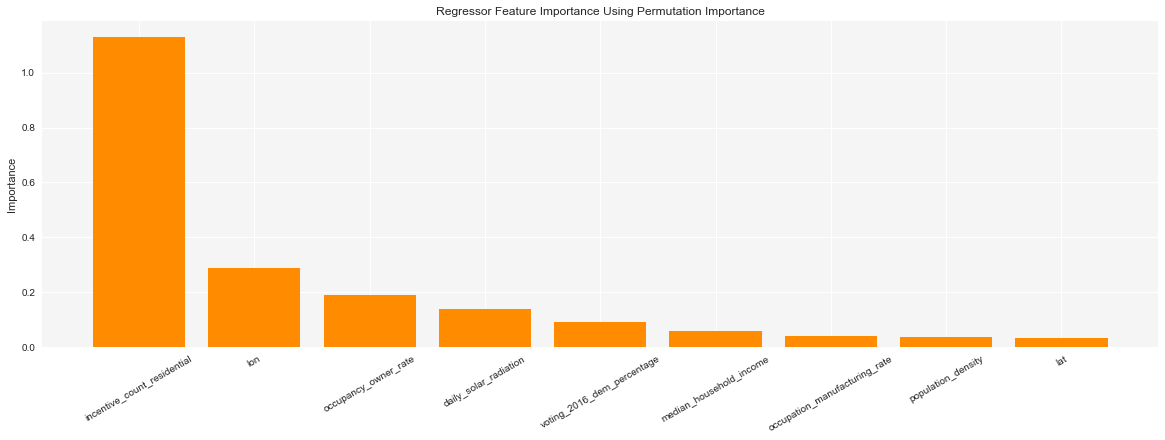

In [142]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values, color='darkorange')
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importance Using Permutation Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names, rotation=30)
plt.show()

Second plot is from the dataset without geographic features

In [167]:
# set up plot values
feature_values_nogeo = regressor_importances_permutation_no_geo[:feature_num]["Importance"]
feature_names_nogeo = regressor_importances_permutation_no_geo[:feature_num].index

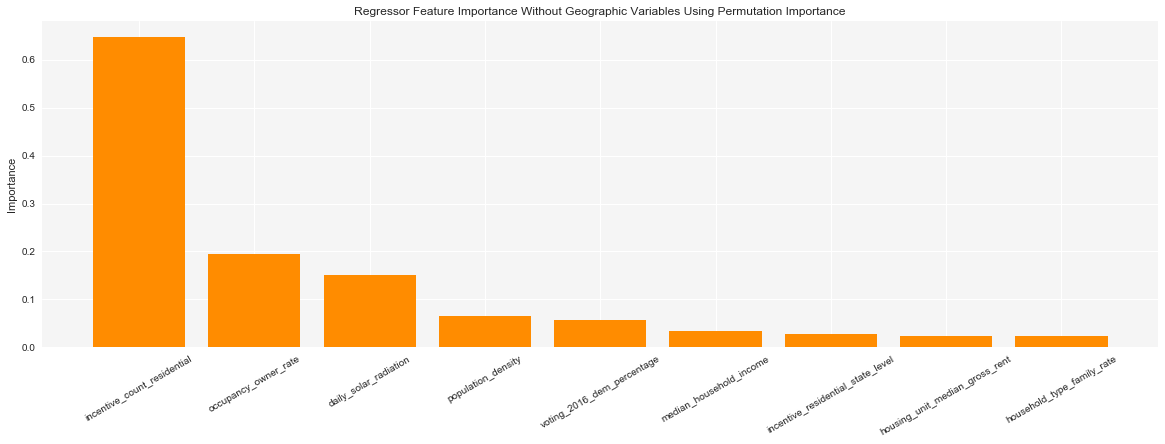

In [168]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values_nogeo, color='darkorange')
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importance Without Geographic Variables Using Permutation Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names_nogeo, rotation=30)
plt.show()

For comparison, the standard gini importances from the regressor on the base dataset

In [143]:
# set up plot values
feature_values_std = regressor_importances_standard[:feature_num]["Importance"]
feature_names_std = regressor_importances_standard[:feature_num].index

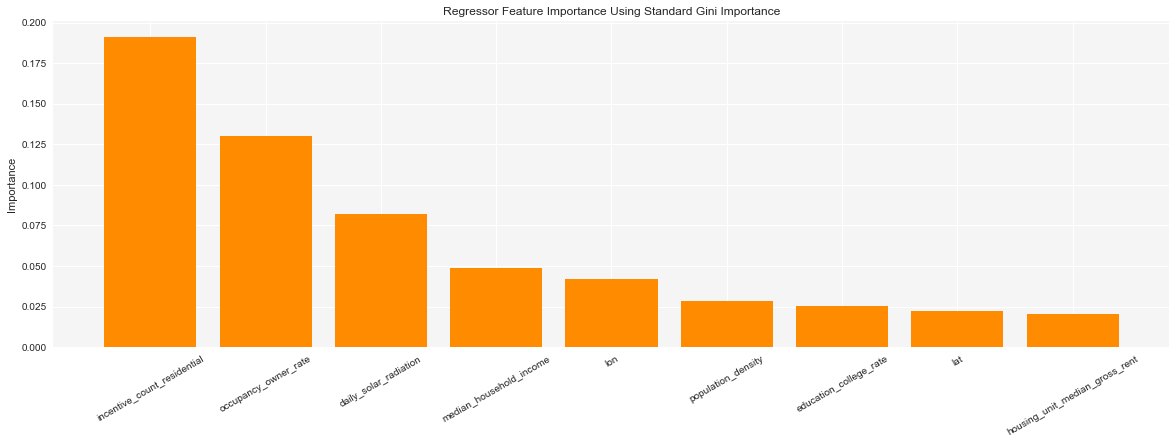

In [144]:
fig,ax=plt.subplots(figsize=(20,6))
ax.bar(feature_index, feature_values_std, color='darkorange')
ax.set_facecolor('whitesmoke')
ax.set_ylabel("Importance")
ax.set_title("Regressor Feature Importance Using Standard Gini Importance")
ax.set_xticks(feature_index)
ax.set_xticklabels(feature_names_std, rotation=30)
plt.show()